In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [3]:
from MMM import mmm

Importing plotly failed. Interactive plots will not work.


# 0. Data Imports

In [4]:
data = pd.read_csv("sales.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]

# 1. Seasonality and Trend Decomposition

To-do
- Convert to method
- Add Holidays optional holidays functionality

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append met

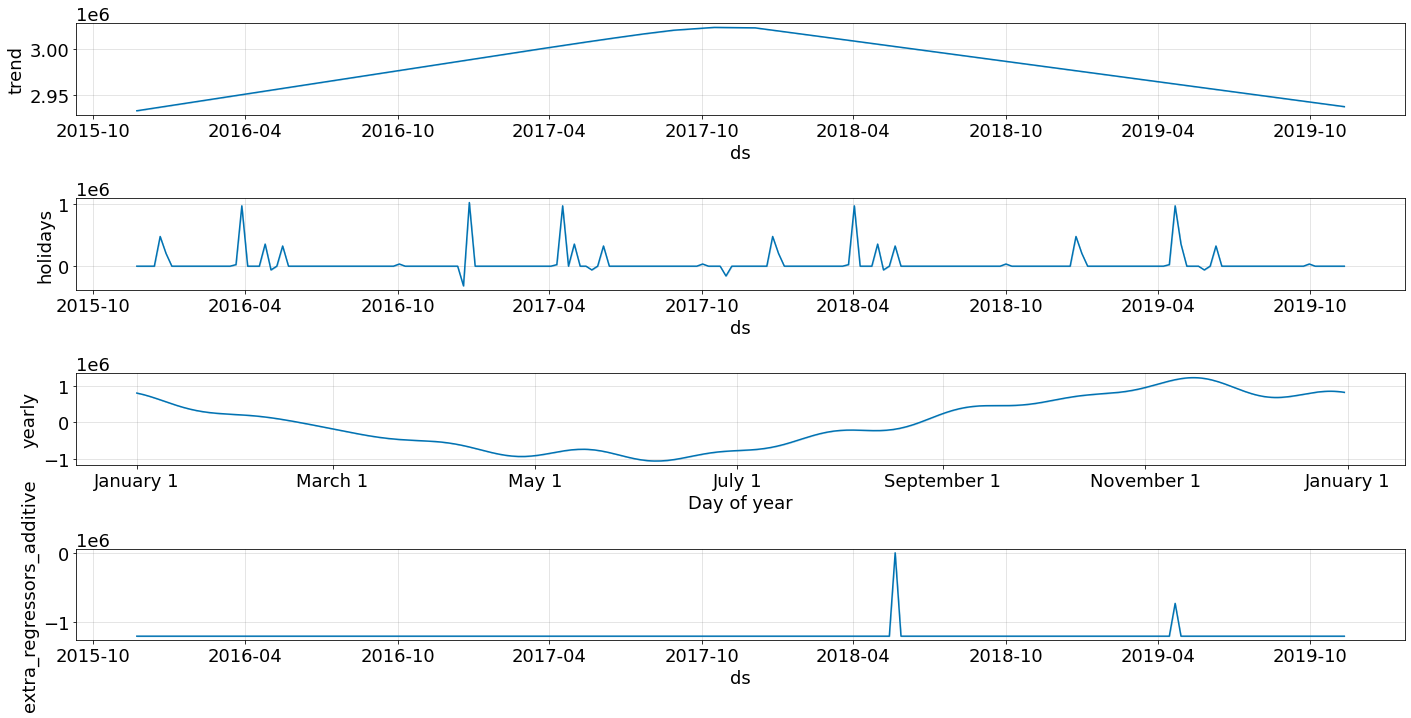

In [5]:
mm_model = mmm()
data = mm_model.decomposition(data, encode_holidays = True, 
                              encode_events = True, 
                              holidays_file = "generated_holidays.csv", 
                              country_code = "DE")
mm_model.plot_decomposition()

# 2. Spend-Exposure estimation

In [6]:
media_spend_exposure_df = mm_model.estimate_spend_exposure(data,
                                                          media_exposures = ["facebook_I", "search_clicks_P"],
                                                          media_spends = ["facebook_S", "search_S"])

# 3. Scaling and Standardization

In [7]:
#choose features/variables to normalize e.g. only independant variables. 
feature_vars = ["trend", 
                "season", 
                "holiday", 
                "competitor_sales_B", 
                "events", 
                "tv_S", 
                "ooh_S", 
                "print_S",
                "facebook_I", 
                "search_clicks_P", 
                "newsletter"]

target_var = "revenue"

def normalize_data(data, feature_vars):
    data_transformed = data.copy()
    numerical_encoder_dict = {}
    
    for feature in feature_vars:
        scaler = MinMaxScaler()
        original = data[feature].values.reshape(-1, 1)
        transformed = scaler.fit_transform(original)
        data_transformed[feature] = transformed
        numerical_encoder_dict[feature] = scaler
        
    return data_transformed

In [8]:
data_transformed = normalize_data(data, feature_vars)

revenue_transformation = MinMaxScaler()
original = data[target_var].values.reshape(-1, 1)
transformed = revenue_transformation.fit_transform(original)
data_transformed[target_var] = transformed

# 4. PYMC3 Model

In [9]:
delay_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"]
control_variables = ["trend", "season", "holiday", "competitor_sales_B", "events"]



mm_model.initialize(data_transformed, 
                    delay_channels, 
                    media_channels, 
                    control_variables, 
                    target_var,
                    revenue_transformation,
                    START_INDEX = 26, 
                    END_INDEX = 130)

Delay Channels: Adding tv_S


INFO:filelock:Lock 140612497411472 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612497411472 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612497082784 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612497082784 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612502985744 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612502985744 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612502731936 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612502731936

Delay Channels: Adding ooh_S


INFO:filelock:Lock 140612521947488 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612521947488 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding print_S


INFO:filelock:Lock 140612530143536 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612530143536 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding facebook_I


INFO:filelock:Lock 140611995438768 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140611995438768 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding search_clicks_P


INFO:filelock:Lock 140612003265600 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612003265600 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding newsletter


INFO:filelock:Lock 140612011224416 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612011224416 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday
Control Variables: Adding competitor_sales_B
Control Variables: Adding events


INFO:filelock:Lock 140612016566080 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612016566080 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612013550080 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612013550080 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612016964944 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612016964944 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612016770160 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612016770160

INFO:filelock:Lock 140612026811872 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612026811872 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612026585200 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612026585200 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612026587552 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612026587552 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612017627680 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612017627680

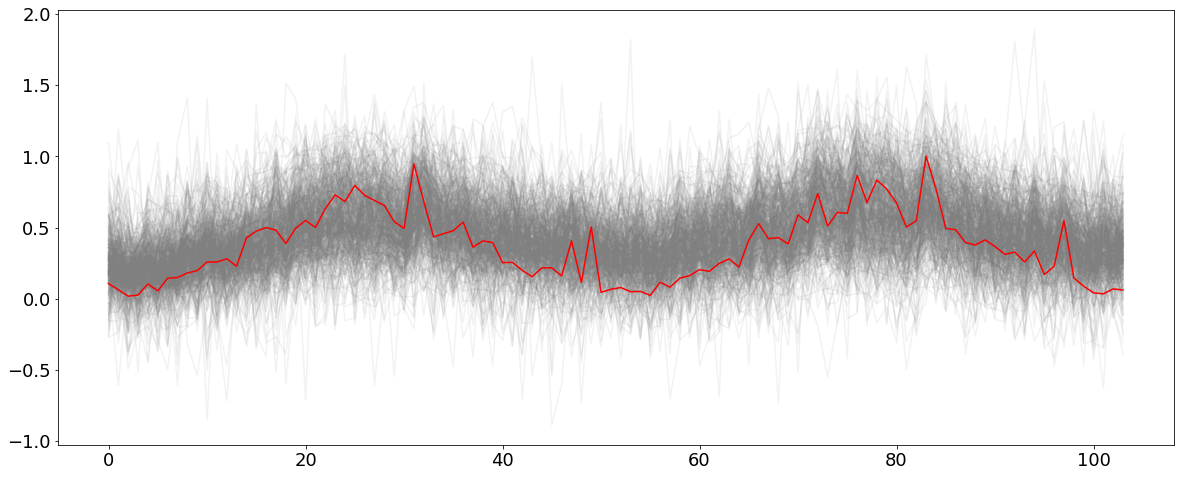

In [10]:
mm_model.plot_prior_predictive(data_transformed)

In [11]:
trace, trace_summary = mm_model.fit(draws = 1000,
                                    tune = 1000, 
                                    chains = 4, 
                                    cores = 4, 
                                    target_accept = 0.95)

INFO:filelock:Lock 140612005145088 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612005145088 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612049884976 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612049884976 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612049740128 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612049740128 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612052196656 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612052196656

INFO:filelock:Lock 140612142659328 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612196873264 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612196873264 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612197615408 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612197615408 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612197687408 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612197687408 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140612200412928

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2470 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2470 seconds.


In [12]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend_control_coef,-0.089,0.022,-0.130,-0.048,0.000,0.000,3549.0,2582.0,1.0
season_control_coef,0.233,0.059,0.121,0.340,0.001,0.001,2915.0,2673.0,1.0
holiday_control_coef,0.339,0.039,0.265,0.410,0.001,0.000,4189.0,2854.0,1.0
competitor_sales_B_control_coef,0.398,0.063,0.282,0.515,0.001,0.001,2729.0,2589.0,1.0
events_control_coef,0.103,0.098,-0.076,0.285,0.001,0.001,5719.0,3378.0,1.0
tv_S_adstock,0.297,0.120,0.071,0.512,0.002,0.002,4050.0,2494.0,1.0
tv_S_gamma,0.275,0.135,0.100,0.556,0.003,0.002,2665.0,2011.0,1.0
tv_S_alpha,2.832,1.368,0.925,5.446,0.025,0.018,2790.0,3181.0,1.0
tv_S_media_coef,0.120,0.036,0.057,0.189,0.001,0.001,2152.0,2463.0,1.0
ooh_S_adstock,0.462,0.170,0.153,0.770,0.002,0.002,5083.0,2752.0,1.0


/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


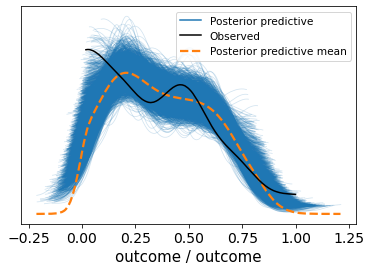

In [13]:
mm_model.plot_posterior_predictive()

In [14]:
mm_model.fit_metrics(data)

RMSE: 184811.99773722503
MAPE: 0.07850577958750514
NRMSE: 0.05961158148716887


# 5. Decomposition

In [15]:
#Apply media transformations on data with optimized parameters.
data_transformed_decomposed = mm_model.apply_transformations(data_transformed)

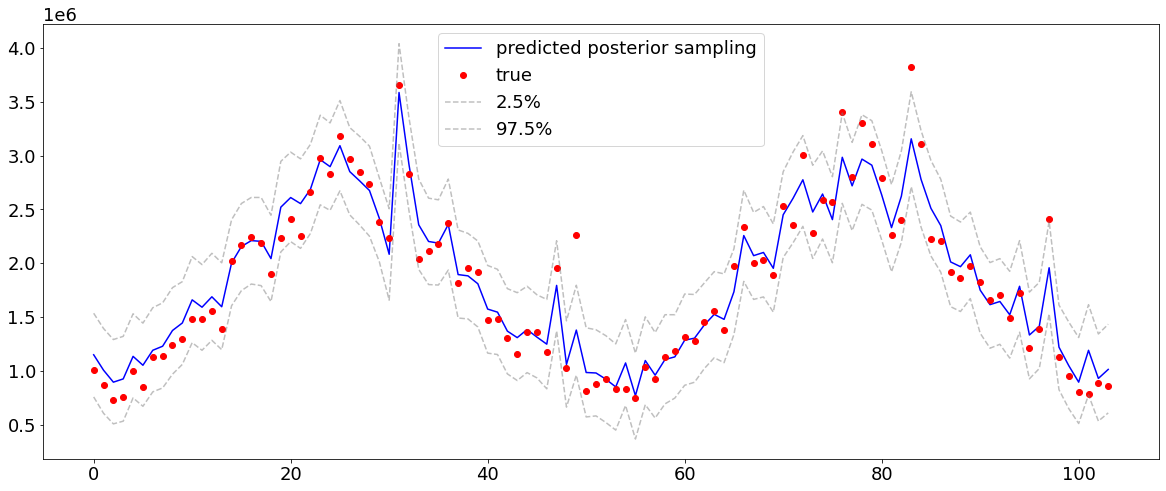

In [16]:
mm_model.plot_model_fit(data_transformed_decomposed)

In [17]:
#Test accuracies
predictions = mm_model.predict(data_transformed_decomposed, 130, 182, return_metrics = True)

RMSE: 259454.13890382802
MAPE: 0.11409324153491943
NRMSE: 0.11195552871285688


In [18]:
spend_response_share_df = mm_model.compute_spend_effect_share(data, data_transformed_decomposed, media_spend_exposure_df)

In [83]:
spend_response_share_df["roi"] = revenue_transformation.inverse_transform(spend_response_share_df["total_effect"].values.reshape(-1, 1)).flatten() / spend_response_share_df['total_spend'] * 100

In [85]:
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share,roi
0,tv_S,1.317091e+07,0.330527,2.443181,0.438818,63.633756
1,ooh_S,1.271114e+07,0.318989,0.512249,0.092005,18.004165
2,print_S,3.175126e+06,0.079680,0.647756,0.116343,85.542900
3,facebook_I,7.183754e+06,0.180278,0.521546,0.093675,32.265433
4,search_clicks_P,3.607324e+06,0.090527,1.442909,0.259160,144.844709


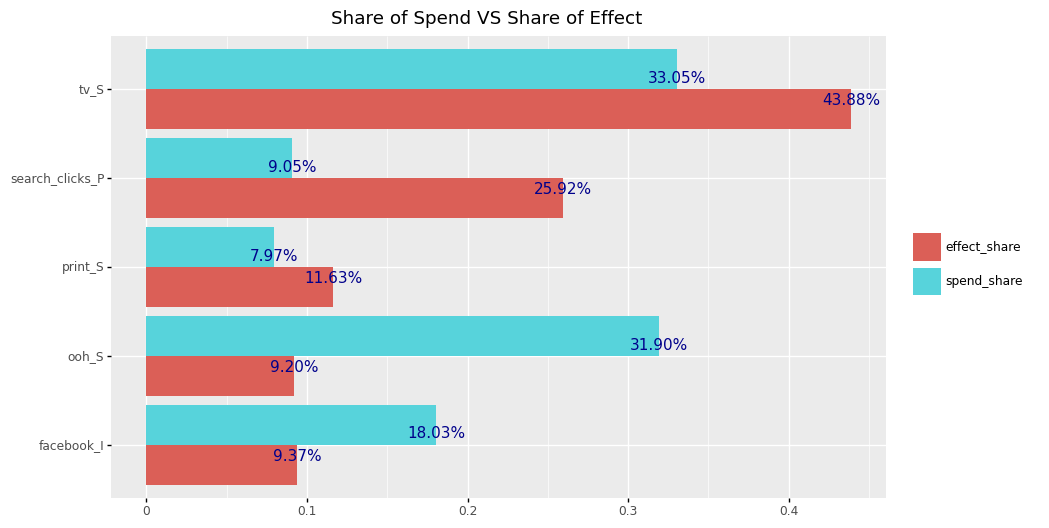

<ggplot: (8788237506624)>

In [20]:
mm_model.plot_spend_vs_effect_share(spend_response_share_df)